In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
from scipy.special import rel_entr

In [2]:
# List of available dataset
df18 = pd.read_csv("../exp2-inf/predictions_res18_2.csv")
df50 = pd.read_csv("../exp2-inf/predictions_res50_2.csv")
df101 = pd.read_csv("../exp2-inf/predictions_res101_2.csv")
label = pd.read_csv("../exp2-inf/labels.csv")

In [3]:
prediction = pd.DataFrame({
    "pred18": df18.idxmax(axis=1),
    "pred50": df50.idxmax(axis=1),
    "pred101": df101.idxmax(axis=1),
    "target": label['target']
})
prediction["pred18"] = prediction["pred18"].str.extract('(\d+)').astype(int)
prediction["pred50"] = prediction["pred50"].str.extract('(\d+)').astype(int)
prediction["pred101"] = prediction["pred101"].str.extract('(\d+)').astype(int)

In [4]:
prediction.head()

,pred18,pred50,pred101,target
0,24,24,24,24
1,77,77,77,77
2,252,252,252,252
3,144,144,144,144
4,224,224,224,224


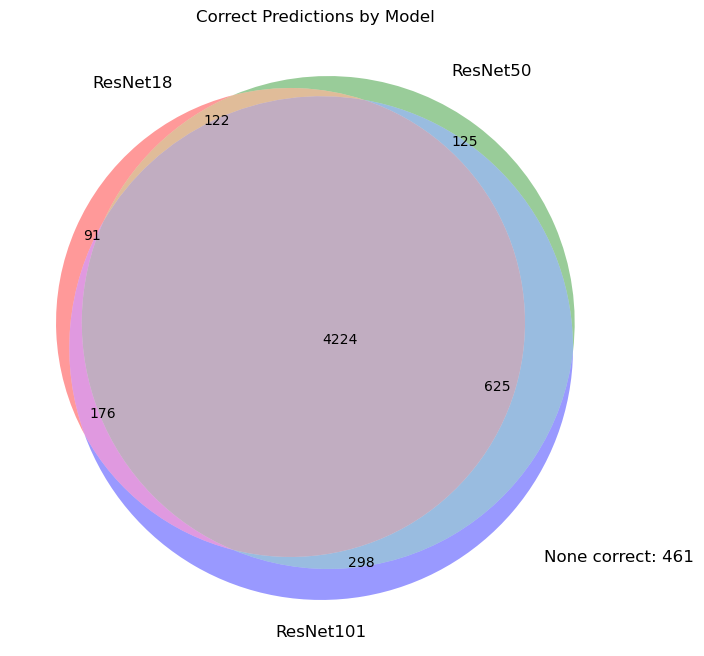

In [5]:
# Accuracy Venn Diagram:
df = prediction
correct_18 = set(df[df['pred18'] == df['target']].index)
correct_50 = set(df[df['pred50'] == df['target']].index)
correct_101 = set(df[df['pred101'] == df['target']].index)
total_indices = set(df.index)
incorrect_all = total_indices - (correct_18 | correct_50 | correct_101)
plt.figure(figsize=(8, 8))
venn_diagram = venn3([correct_18, correct_50, correct_101], ('ResNet18', 'ResNet50', 'ResNet101'))
plt.title('Correct Predictions by Model')
plt.text(0.5, -0.5, f'None correct: {len(incorrect_all)}', fontsize=12)
plt.show()

ou_res18=0.5967268844268535 | ou_res50=0.35323308562895256 | ou_res101=0.15073991393094044


Text(0, 0.5, 'Density')

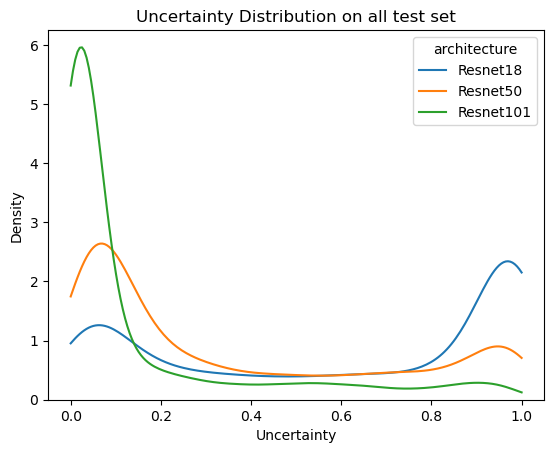

In [6]:
# Uncertainty Visualization
df18["uncertainty"]=1-df18.pow(2).sum(axis=1) # Brier Score
df50["uncertainty"]=1-df50.pow(2).sum(axis=1)
df101["uncertainty"]=1-df101.pow(2).sum(axis=1)
ou_res18 = df18["uncertainty"].mean()
ou_res50 = df50["uncertainty"].mean()
ou_res101 = df101["uncertainty"].mean()
print(f"{ou_res18=} | {ou_res50=} | {ou_res101=}")
sns.kdeplot(df18['uncertainty'], clip=[0, 1], label='Resnet18')
sns.kdeplot(df50['uncertainty'], clip=[0, 1], label='Resnet50')
sns.kdeplot(df101['uncertainty'], clip=[0, 1], label='Resnet101')
plt.legend(title='architecture')
plt.title('Uncertainty Distribution on all test set')
plt.xlabel('Uncertainty')
plt.ylabel('Density')

oc_res18=0.9039513037027024 | oc_res50=0.8942049228363482 | oc_res101=0.9388096569812723


Text(0, 0.5, 'Density')

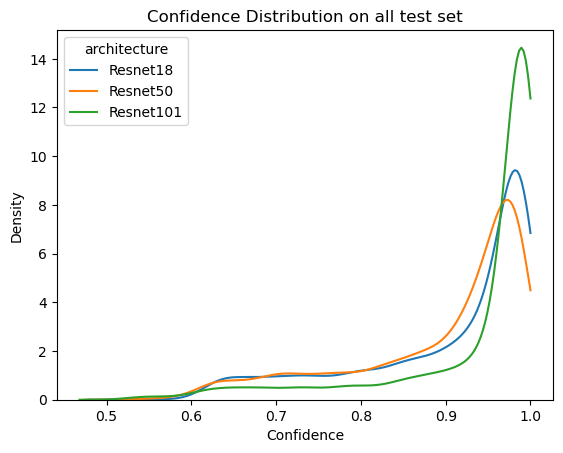

In [7]:
df18["confidence"]=df18.max(axis=1) # prediction confidence
df50["confidence"]=df50.max(axis=1)
df101["confidence"]=df101.max(axis=1)
oc_res18 = df18["confidence"].mean()
oc_res50 = df50["confidence"].mean()
oc_res101 = df101["confidence"].mean()
print(f"{oc_res18=} | {oc_res50=} | {oc_res101=}")
sns.kdeplot(df18['confidence'], clip=[0, 1], label='Resnet18')
sns.kdeplot(df50['confidence'], clip=[0, 1], label='Resnet50')
sns.kdeplot(df101['confidence'], clip=[0, 1], label='Resnet101')
plt.title('Confidence Distribution on all test set')
plt.legend(title='architecture')
plt.xlabel('Confidence')
plt.ylabel('Density')

In [8]:
df["acc18"] = np.where(df["pred18"]==df["target"],1,0)
df["acc50"] = np.where(df["pred50"]==df["target"],1,0)
df["acc101"] = np.where(df["pred101"]==df["target"],1,0)
oa_res18 = df["acc18"].mean()
oa_res50 = df["acc50"].mean()
oa_res101 = df["acc101"].mean()
print(f"{oa_res18=} | {oa_res50=} | {oa_res101=}")

oa_res18=0.7535119242077752 | oa_res50=0.8324077098987259 | oa_res101=0.8694870957203529


/Users/timothyzhou/anaconda3/envs/cpsc340/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/timothyzhou/anaconda3/envs/cpsc340/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/timothyzhou/anaconda3/envs/cpsc340/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/timothyzhou/anaconda3/envs/cpsc340/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/timothyzhou/anaconda3/envs/cpsc340/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inp

,pred18,pred50,pred101,target,acc18,acc50,acc101,kl_18_50,kl_18_101,kl_50_18,kl_50_101,kl_101_18,kl_101_50
0,24,24,24,24,1,1,1,-2.252880,0.493671,-0.794514,0.266037,1.310837,0.529287
1,77,77,77,77,1,1,1,-2.036682,-0.935347,-2.658922,-1.269154,-0.414413,-0.348139


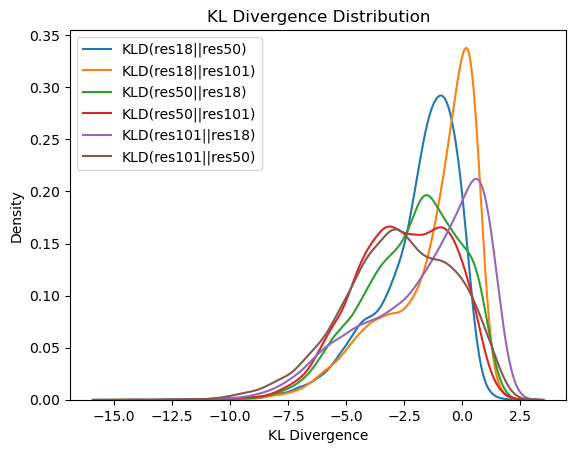

In [9]:
def calc_kl(Q,P,numclass):
    return np.log(rel_entr(Q.iloc[:,0:numclass],P.iloc[:,0:numclass]).sum(1))
df["kl_18_50"] = calc_kl(df18,df50,100)
df["kl_18_101"] = calc_kl(df18,df101,100)
df["kl_50_18"] = calc_kl(df50,df18,100)
df["kl_50_101"] = calc_kl(df50,df101,100)
df["kl_101_18"] = calc_kl(df101,df18,100)
df["kl_101_50"] = calc_kl(df101,df50,100)
display(df.head(2))
sns.kdeplot(df["kl_18_50"], label='KLD(res18||res50)')
sns.kdeplot(df["kl_18_101"], label='KLD(res18||res101)')
sns.kdeplot(df["kl_50_18"], label='KLD(res50||res18)')
sns.kdeplot(df["kl_50_101"], label='KLD(res50||res101)')
sns.kdeplot(df["kl_101_18"], label='KLD(res101||res18)')
sns.kdeplot(df["kl_101_50"], label='KLD(res101||res50)')
plt.title('KL Divergence Distribution')
plt.xlabel('KL Divergence')
plt.ylabel('Density')
plt.legend()

bin_kl
(-11.853, -10.473]       2
(-10.473, -9.107]        6
(-9.107, -7.74]         25
(-7.74, -6.374]         79
(-6.374, -5.008]       243
(-5.008, -3.642]       532
(-3.642, -2.276]       866
(-2.276, -0.91]       1883
(-0.91, 0.457]        1704
(0.457, 1.823]          94
Name: count, dtype: int64


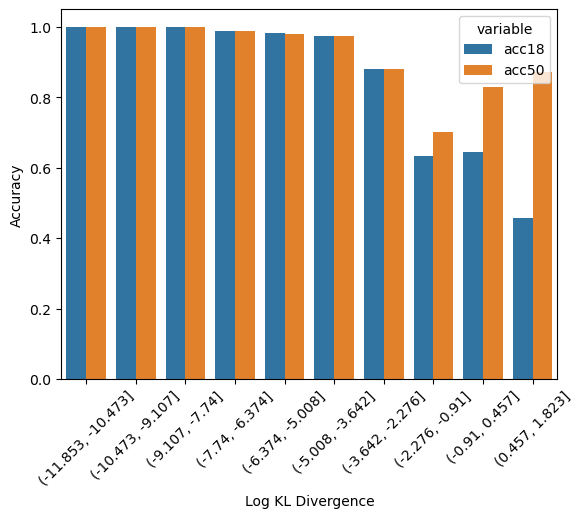

bin_kl
(-12.153, -10.716]       1
(-10.716, -9.294]        4
(-9.294, -7.872]        21
(-7.872, -6.449]        70
(-6.449, -5.027]       261
(-5.027, -3.605]       550
(-3.605, -2.182]       701
(-2.182, -0.76]       1163
(-0.76, 0.662]        2689
(0.662, 2.085]         392
Name: count, dtype: int64


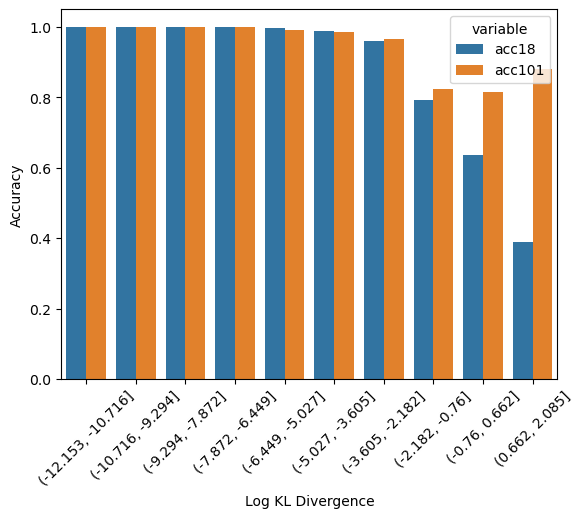

bin_kl
(-11.592, -10.253]       1
(-10.253, -8.928]        5
(-8.928, -7.602]        24
(-7.602, -6.276]       100
(-6.276, -4.951]       311
(-4.951, -3.625]       521
(-3.625, -2.299]       760
(-2.299, -0.974]      1033
(-0.974, 0.352]        847
(0.352, 1.678]         447
Name: count, dtype: int64


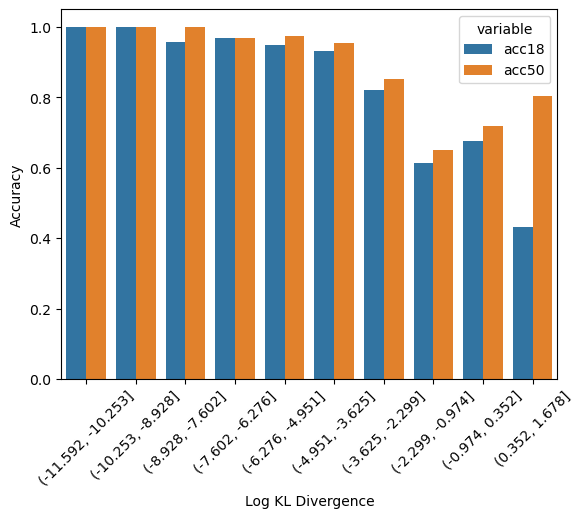

bin_kl
(-11.164, -9.823]       9
(-9.823, -8.495]       14
(-8.495, -7.168]       70
(-7.168, -5.84]       255
(-5.84, -4.512]       660
(-4.512, -3.184]     1114
(-3.184, -1.856]     1180
(-1.856, -0.528]     1198
(-0.528, 0.799]       910
(0.799, 2.127]        114
Name: count, dtype: int64


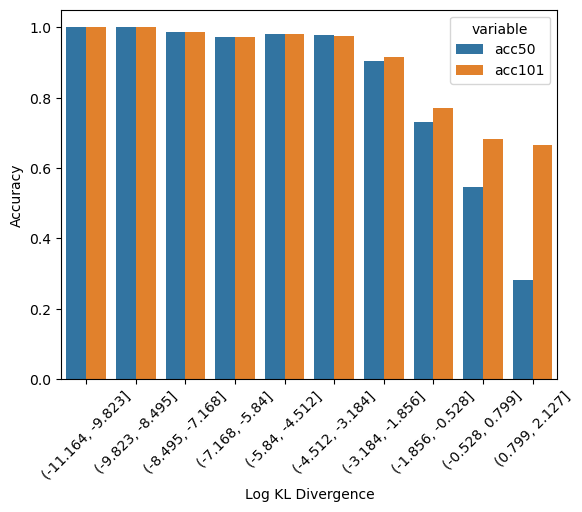

bin_kl
(-12.774, -11.296]      1
(-11.296, -9.833]       5
(-9.833, -8.369]       17
(-8.369, -6.906]       70
(-6.906, -5.443]      199
(-5.443, -3.98]       294
(-3.98, -2.517]       378
(-2.517, -1.054]      507
(-1.054, 0.409]       737
(0.409, 1.872]        802
Name: count, dtype: int64


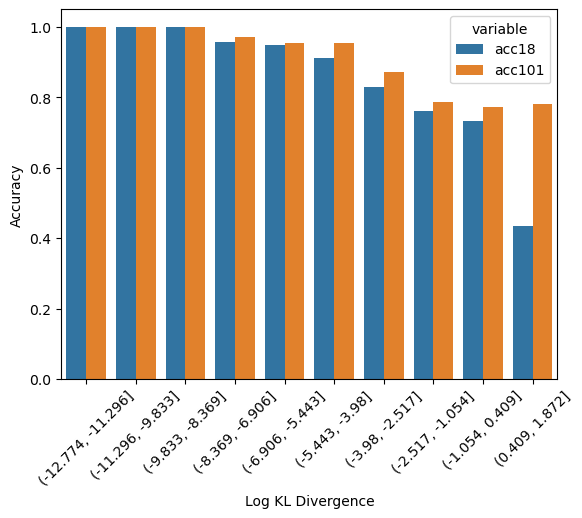

bin_kl
(-14.52, -12.843]       1
(-12.843, -11.183]      0
(-11.183, -9.523]      14
(-9.523, -7.863]       55
(-7.863, -6.203]      169
(-6.203, -4.543]      402
(-4.543, -2.883]      763
(-2.883, -1.223]      752
(-1.223, 0.437]       642
(0.437, 2.097]        244
Name: count, dtype: int64


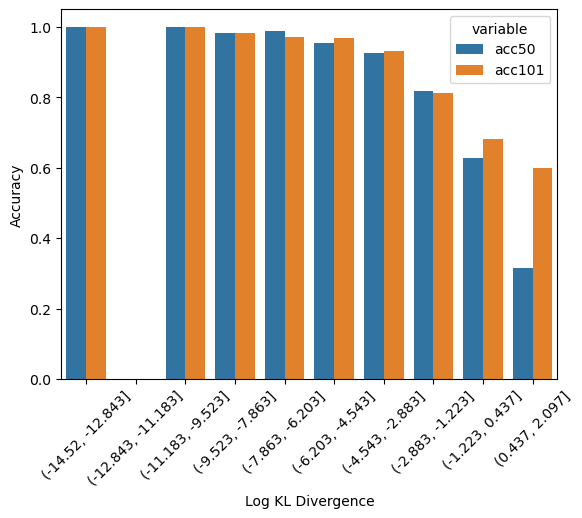

In [10]:
binnum=10
def bin_kl_vis(df_in, binnum,kl_name,acc_col1,acc_col2):
    df=df_in
    tempcol = "bin_kl"
    df[tempcol] = pd.cut(df[kl_name].clip(-20,10), bins=binnum)
    print(df[tempcol].value_counts().sort_index())
    grouped = df.groupby(tempcol)[[acc_col1,acc_col2]].mean().reset_index()
    melted_grouped = grouped.melt(id_vars=tempcol, var_name='variable', value_name='value')
    sns.barplot(x=tempcol, y='value', hue='variable', data=melted_grouped)
    plt.xticks(rotation=45)
    plt.xlabel("Log KL Divergence")
    plt.ylabel("Accuracy")
    plt.show()
bin_kl_vis(df, binnum, "kl_18_50", "acc18", "acc50")
bin_kl_vis(df, binnum, "kl_18_101", "acc18", "acc101")
bin_kl_vis(df, binnum, "kl_50_18", "acc18", "acc50")
bin_kl_vis(df, binnum, "kl_50_101", "acc50", "acc101")
bin_kl_vis(df, binnum, "kl_101_18", "acc18", "acc101")
bin_kl_vis(df, binnum, "kl_101_50", "acc50", "acc101")